# Import and Clean data

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB

import nltk 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.probability import FreqDist

import gensim.corpora as corpora
import gensim.downloader as api
import gensim
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from wordcloud import WordCloud

from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [2]:
df=pd.read_csv('company.csv', encoding= 'unicode_escape')
df.drop('emotion_in_tweet_is_directed_at', axis=1,inplace=True)
df.columns=['tweet_text', 'sentiment']

In [3]:
df.isnull().sum()

tweet_text    1
sentiment     0
dtype: int64

In [4]:
df.dropna(inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  9092 non-null   object
 1   sentiment   9092 non-null   object
dtypes: object(2)
memory usage: 213.1+ KB


# Tokenize, Lemmatize, Stop Words

There are a lot of similar words appear in both "positive emotion" and "negative emotion", such as: mention, google, today which are insignificant in my models. Therefore, I also added them to stop words list to drop them.

In [6]:
tokenizer=RegexpTokenizer(r'[a-zA-Z]+')
stop_words=list(stopwords.words("english"))
stop_words+=['sxsw','mention', 'link', 'ipad', 'rt', 'google', 'apple', 'quot', 'iphone', 'store',
             'app', 'amp', 'austin','new','pop','social', 'sxswi', 'today','launch', 'android', 'g',
            'circles', 'w', 'u', 'like', 'line']

In [7]:
raw_data=df.tweet_text
target=df.sentiment

In [8]:
def process_article(article):
    tokens = tokenizer.tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed 

In [9]:
# applying the above function to our data/features 
processed_raw_data = list(map(process_article, raw_data))

In [10]:
df[df['tweet_text'].str.contains("circle")]

,tweet_text,sentiment
159,Anyone at #sxsw or heading to aclu event seen ...,No emotion toward brand or product
312,Those who are tweeting that Google is coming o...,No emotion toward brand or product
422,Google to debut new selective social network t...,No emotion toward brand or product
711,.@mention is competing with @mention circles o...,No emotion toward brand or product
772,Google to Launch Major New Social Network Call...,No emotion toward brand or product
...,...,...
8745,Ben benieuwd! RT @mention We interrupt your re...,Positive emotion
8785,#google (via @mention denies it will be launch...,No emotion toward brand or product
9031,... or maybe not: {link} #google #circles #sxsw,No emotion toward brand or product
9078,Cue the hype RT @mention We interrupt your reg...,No emotion toward brand or product


In [11]:
total_vocab = set()
for comment in processed_raw_data:
    total_vocab.update(comment)
len(total_vocab)

9123

In [12]:
lemmatizer=WordNetLemmatizer()

In [13]:
# creating a list with all lemmatized outputs
lemmatized_output = []

for listy in processed_raw_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [14]:
clean_data=pd.DataFrame(lemmatized_output, columns=['text'])

In [15]:
clean_data

,text
0,wesley hr tweeting rise dead need upgrade plug...
1,jessedee know fludapp awesome likely appreciat...
2,swonderlin wait also sale
3,hope year festival crashy year
4,sxtxstate great stuff fri marissa mayer tim re...
...,...
9087,everywhere
9088,wave buzz interrupt regularly scheduled geek p...
9089,zeiger physician never reported potential ae y...
9090,verizon customer complained time fell back hou...


In [16]:
data=pd.concat([clean_data, target], axis=1)

In [17]:
data.dropna(inplace=True)

# EDA

In [18]:
data.head()

,text,sentiment
0,wesley hr tweeting rise dead need upgrade plug...,Negative emotion
1,jessedee know fludapp awesome likely appreciat...,Positive emotion
2,swonderlin wait also sale,Positive emotion
3,hope year festival crashy year,Negative emotion
4,sxtxstate great stuff fri marissa mayer tim re...,Positive emotion


In [19]:
data.sentiment.value_counts()

No emotion toward brand or product    5387
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

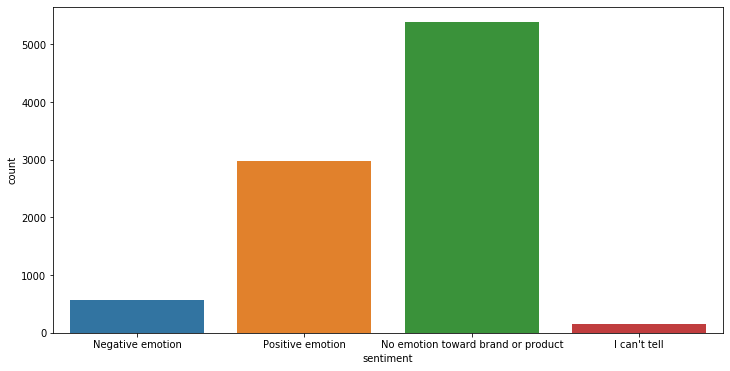

In [20]:
fig=plt.figure(figsize=(12,6))
sns.countplot(x='sentiment', data=data)
plt.show()

Base on plot above, "No Emotion" has the most tweets. However, "No Emotion" and "I can't tell" have no significant in my purpose. I only focus on "Negative emotion" and "Positive emotion", so I decided to drop insignificant tweets

In [21]:
#Drop hesitation and no emotion columns
data=data[(data['sentiment']!="I can't tell") & (data['sentiment']!='No emotion toward brand or product')] 

In [22]:
data.sentiment.value_counts()

Positive emotion    2978
Negative emotion     570
Name: sentiment, dtype: int64

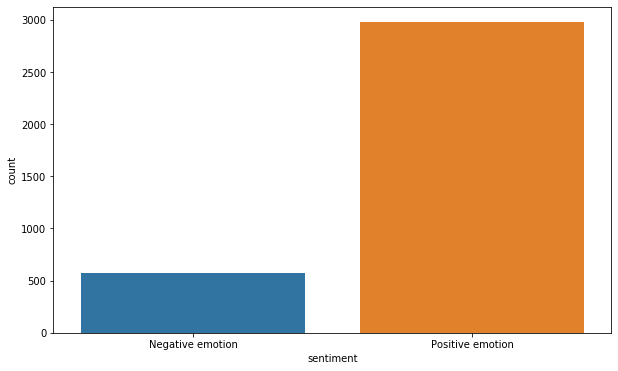

In [23]:
fig=plt.figure(figsize=(10,6))
sns.countplot(x='sentiment', data=data)
plt.show()

In [24]:
data

,text,sentiment
0,wesley hr tweeting rise dead need upgrade plug...,Negative emotion
1,jessedee know fludapp awesome likely appreciat...,Positive emotion
2,swonderlin wait also sale,Positive emotion
3,hope year festival crashy year,Negative emotion
4,sxtxstate great stuff fri marissa mayer tim re...,Positive emotion
...,...,...
9077,cue hype interrupt regularly scheduled geek pr...,Positive emotion
9079,diller say tv might run playstation xbox essen...,Positive emotion
9080,say report network incorrect rate,Negative emotion
9085,say want give lightning talk h ckers audience ...,Positive emotion


In [25]:
#set index for new data
data.index = np.arange(1, len(data)+1)

In [26]:
data

,text,sentiment
1,wesley hr tweeting rise dead need upgrade plug...,Negative emotion
2,jessedee know fludapp awesome likely appreciat...,Positive emotion
3,swonderlin wait also sale,Positive emotion
4,hope year festival crashy year,Negative emotion
5,sxtxstate great stuff fri marissa mayer tim re...,Positive emotion
...,...,...
3544,cue hype interrupt regularly scheduled geek pr...,Positive emotion
3545,diller say tv might run playstation xbox essen...,Positive emotion
3546,say report network incorrect rate,Negative emotion
3547,say want give lightning talk h ckers audience ...,Positive emotion


For EDA, I need to seperate "Positive emotion" and "Negative emotion"

In [27]:
# applying the above function to our new datas
processed_data = list(map(process_article, data.text))

In [28]:
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

5377

After dropping insignificant tweets, total words reduce from 9123 words to 5377 words

In [29]:
neg_emo=data[data['sentiment']=='Negative emotion']
pos_emo=data[data.sentiment=='Positive emotion']

In [30]:
neg_emo.head()

,text,sentiment
1,wesley hr tweeting rise dead need upgrade plug...,Negative emotion
4,hope year festival crashy year,Negative emotion
15,added flight planely matching people plane air...,Negative emotion
31,vatornews force print medium evolve,Negative emotion
40,agree wait fiona town somebody kidnap put reco...,Negative emotion


In [31]:
#neg_words=[]
#for text in data.text.to_string():
 #   tokens = tokenizer.tokenize(text)
  #  neg_words.append(tokens)

In [32]:
def word_tokenizer(data, col):
    token=[]
    for item in data[col]:
        token.extend(tokenizer.tokenize(item))
    return token

In [33]:
#Tokenizer on negative and positive datasets
ttw_neg=word_tokenizer(neg_emo,'text')
ttw_pos=word_tokenizer(pos_emo,'text')

In [34]:
len(set(ttw_pos))

4939

In [35]:
len(set(ttw_neg))

1813

In [36]:
freq_neg=FreqDist(ttw_neg)
freq_pos=FreqDist(ttw_pos)

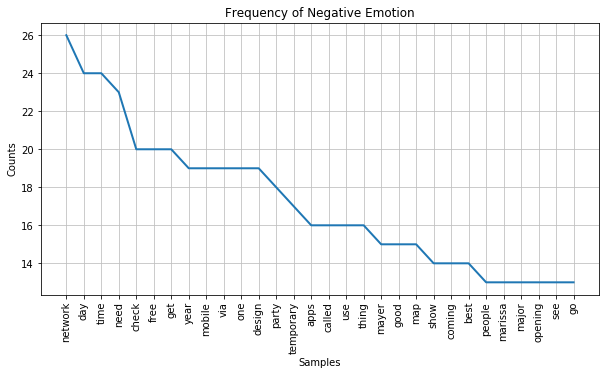

In [37]:
plt.figure(figsize=(10,5))
freq_neg.plot(30, title='Frequency of Negative Emotion')
plt.show()

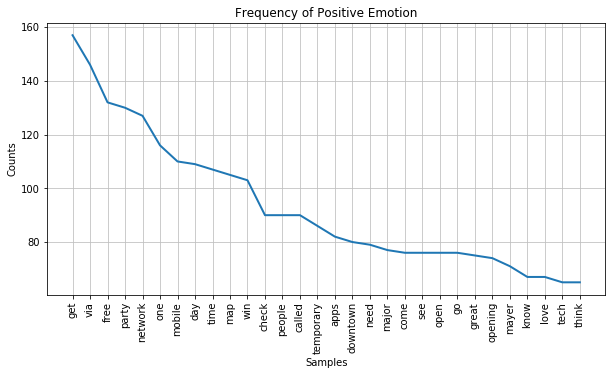

In [87]:
plt.figure(figsize=(10,5))
freq_pos.plot(30, title='Frequency of Positive Emotion')
plt.show()

# Word Clouds


In [88]:
dict(freq_neg.most_common(10))

{'network': 26,
 'day': 24,
 'time': 24,
 'need': 23,
 'check': 20,
 'free': 20,
 'get': 20,
 'year': 19,
 'mobile': 19,
 'via': 19}

In [40]:
#neg_counts = [x[1] for x in freq_neg.most_common(25)]
#neg_words=[x[0] for x in freq_neg.most_common(25)]

#pos_counts = [x[1] for x in freq_pos.most_common(25)]
#pos_words=[x[0] for x in freq_pos.most_common(25)]

#np_counts = [x[1] for x in freq_np.most_common(25)]
#np_words=[x[0] for x in freq_np.most_common(25)]

#hes_counts = [x[1] for x in freq_hes.most_common(25)]
#hes_words=[x[0] for x in freq_hes.most_common(25)]


In [90]:
dict(freq_pos.most_common(10))

{'get': 157,
 'via': 146,
 'free': 132,
 'party': 130,
 'network': 127,
 'one': 116,
 'mobile': 110,
 'day': 109,
 'time': 107,
 'map': 105}

In [84]:
# Getting our data into a dictionary
neg_dict = dict(freq_neg.most_common(30))
pos_dict = dict(freq_pos.most_common(30))

In [85]:
def word_cloud(dictionary):
    # Create the word cloud:

    wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(dictionary)

# Display the generated image w/ matplotlib:

    plt.figure(figsize=(10,10), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    
# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

    plt.show()

In [43]:
word_dicts=[neg_dict, pos_dict]

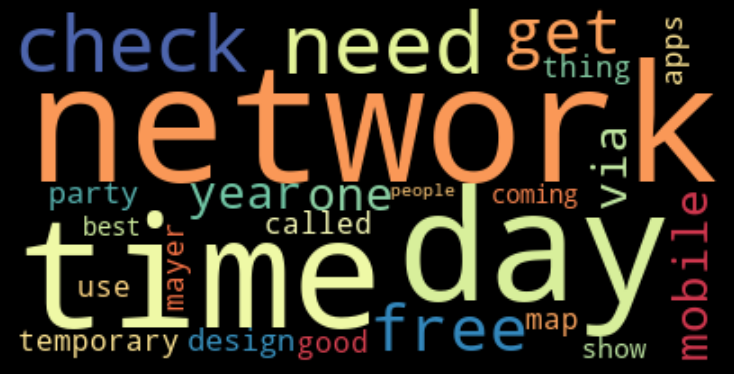

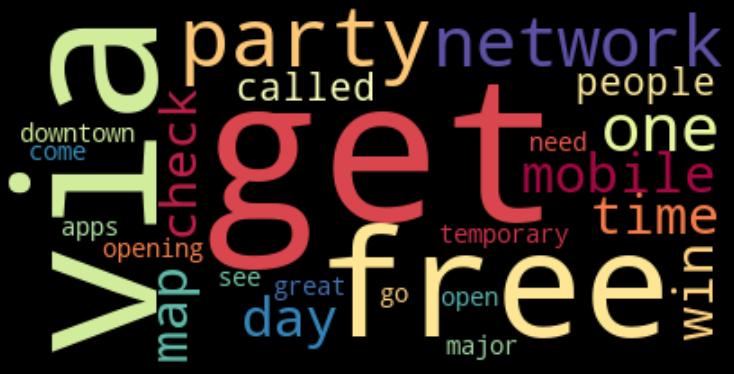

In [86]:
for dictionary in word_dicts:
    word_cloud(dictionary)

# Feature Engineering

In [45]:
data.head()

,text,sentiment
1,wesley hr tweeting rise dead need upgrade plug...,Negative emotion
2,jessedee know fludapp awesome likely appreciat...,Positive emotion
3,swonderlin wait also sale,Positive emotion
4,hope year festival crashy year,Negative emotion
5,sxtxstate great stuff fri marissa mayer tim re...,Positive emotion


In [46]:
#I SMOTE my dataset later, so I need to convert sentiment columns to numeric
data['sentiment']=data['sentiment'].map({'Positive emotion':1, 'Negative emotion':0})

In [47]:
data

,text,sentiment
1,wesley hr tweeting rise dead need upgrade plug...,0
2,jessedee know fludapp awesome likely appreciat...,1
3,swonderlin wait also sale,1
4,hope year festival crashy year,0
5,sxtxstate great stuff fri marissa mayer tim re...,1
...,...,...
3544,cue hype interrupt regularly scheduled geek pr...,1
3545,diller say tv might run playstation xbox essen...,1
3546,say report network incorrect rate,0
3547,say want give lightning talk h ckers audience ...,1


In [48]:
X=data.text
y=data.sentiment

In [49]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.25, random_state=10)

Word Vectorization

In [50]:
vec = CountVectorizer(stop_words=None)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

In [51]:
#make a dataframe to check my data after count vectorizer
X_train_vec_df = pd.DataFrame(X_train_vec.toarray(), columns = vec.get_feature_names())
X_train_vec_df

,aapl,aaron,ab,abba,ability,able,abound,absolutely,abt,abuzz,...,zinio,zlf,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


TF-IDF

In [52]:
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf

<2661x4599 sparse matrix of type '<class 'numpy.float64'>'
	with 18447 stored elements in Compressed Sparse Row format>

In [53]:
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns = tfidf.get_feature_names())
X_train_tfidf_df.head(100)

,aapl,aaron,ab,abba,ability,able,abound,absolutely,abt,abuzz,...,zinio,zlf,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Word Embedding

In [54]:
import spacy
nlp = spacy.load('en_core_web_md')

In [55]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [56]:
X_train['spacy']=X_train.progress_apply(lambda x: nlp(x))

In [57]:
X_test['spacy']=X_test.progress_apply(lambda x: nlp(x))

In [58]:
X_train_spacy = pd.DataFrame(np.vstack([x.vector for x in X_train.spacy]))
X_test_spacy = pd.DataFrame(np.vstack([x.vector for x in X_test.spacy]))

In [59]:
X_train_spacy

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.203900,0.211542,-0.084082,-0.088217,0.037332,-0.024469,0.149272,-0.208719,0.026035,1.372966,...,0.026345,0.056989,0.001781,-0.018079,0.235961,-0.028179,-0.124586,0.013286,-0.063505,0.045010
1,0.208860,0.019876,0.078569,0.142440,0.094697,-0.000312,0.100352,-0.040185,0.013240,2.123183,...,-0.015212,0.001248,-0.066038,0.088987,-0.069278,0.028697,0.073887,0.067611,0.068561,0.169267
2,-0.057773,-0.022018,-0.073996,-0.032028,-0.062558,-0.010446,-0.131255,0.092591,-0.037600,2.086000,...,-0.213149,0.038918,0.092393,-0.016919,-0.052049,0.026296,0.053330,-0.095592,0.010766,0.208394
3,-0.126600,-0.063422,-0.299077,0.049299,0.024020,-0.108165,-0.309396,-0.073646,0.107655,1.544455,...,0.086590,-0.293215,-0.038709,0.080833,0.031710,-0.069457,-0.132525,0.223963,-0.249379,0.437250
4,0.146832,0.050342,-0.154879,-0.002425,0.099069,-0.024895,-0.053974,-0.116202,0.089873,2.219472,...,-0.236990,-0.001106,0.113842,-0.076997,0.236725,-0.113652,-0.082183,0.038029,-0.035500,0.199425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,-0.313011,0.128361,-0.219825,-0.090006,0.161477,0.000754,0.009128,-0.000963,-0.019786,2.307100,...,-0.034737,0.033300,-0.079227,-0.034680,0.001299,0.203279,0.085933,0.279777,0.158505,0.113566
2657,-0.018928,0.046195,0.008290,-0.029659,0.127507,-0.069058,0.063807,-0.307471,0.160326,1.730483,...,-0.020959,-0.037878,-0.157806,0.116493,0.225503,-0.057737,0.047324,0.003325,-0.150712,0.218165
2658,-0.051524,0.053791,-0.136162,-0.020514,0.111291,-0.051523,0.031338,0.070794,0.104144,1.645756,...,-0.230026,0.134363,-0.080911,0.027428,-0.026559,0.219203,0.097236,-0.145246,-0.006774,-0.007223
2659,-0.049991,0.171613,-0.200968,-0.022640,0.117401,0.075243,-0.061723,0.037907,0.051438,2.438825,...,-0.219058,0.141181,-0.090045,0.080083,-0.133096,-0.029295,0.189078,-0.121644,-0.131144,0.139013


# Naive Bayes

In [60]:
#Define a function to iterate models
def run_model(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_tr_pred=model.predict(x_train)
    y_pred=model.predict(x_test)
    metrics_train=classification_report(y_train, y_tr_pred)
    metrics_test=classification_report(y_test, y_pred)
    fig1, ax1=plt.subplots(figsize=[7,7])
    plot_train=plot_confusion_matrix(model,x_train, y_train, ax=ax1)
    plt.show()
    
    print('\n')
    print('The Metrics train set')
    print(metrics_train)
    fig2, ax2= plt.subplots(figsize=[7,7])
    plot_test=plot_confusion_matrix(model,x_test, y_test, ax=ax2)
    plt.show()
    print('\n')
    print('The Metrics test set')
    print(metrics_test)

In [61]:
nb=GaussianNB()

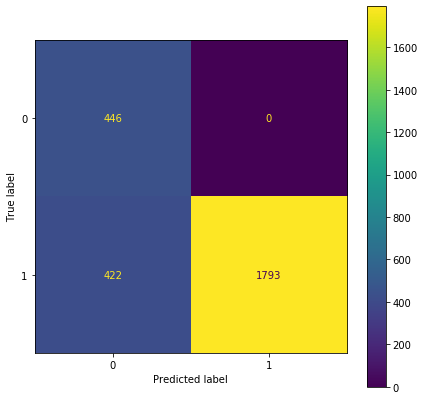



The Metrics train set
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       446
           1       1.00      0.81      0.89      2215

    accuracy                           0.84      2661
   macro avg       0.76      0.90      0.79      2661
weighted avg       0.92      0.84      0.86      2661



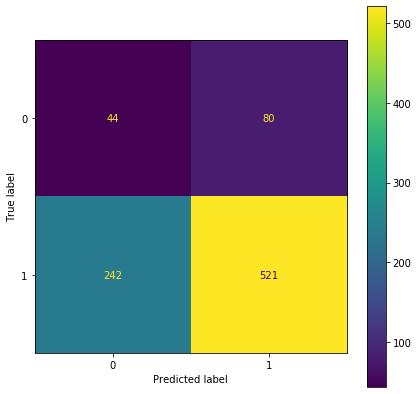



The Metrics test set
              precision    recall  f1-score   support

           0       0.15      0.35      0.21       124
           1       0.87      0.68      0.76       763

    accuracy                           0.64       887
   macro avg       0.51      0.52      0.49       887
weighted avg       0.77      0.64      0.69       887



In [62]:
vec_nb=run_model(nb,X_train_vec.toarray(), X_test_vec.toarray(), y_train, y_test )

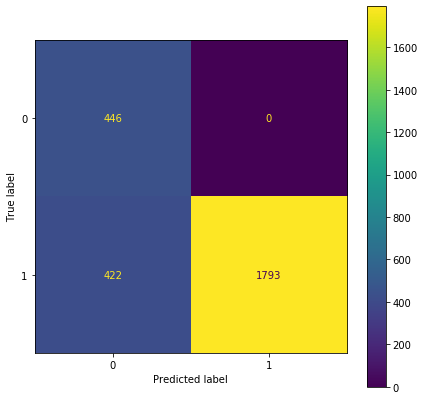



The Metrics train set
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       446
           1       1.00      0.81      0.89      2215

    accuracy                           0.84      2661
   macro avg       0.76      0.90      0.79      2661
weighted avg       0.92      0.84      0.86      2661



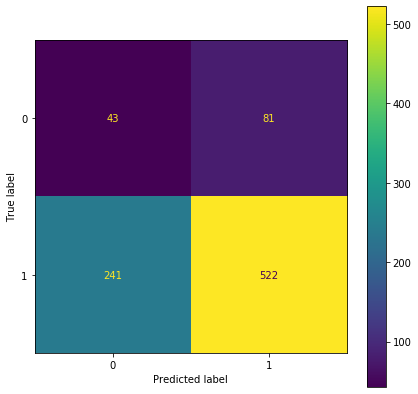



The Metrics test set
              precision    recall  f1-score   support

           0       0.15      0.35      0.21       124
           1       0.87      0.68      0.76       763

    accuracy                           0.64       887
   macro avg       0.51      0.52      0.49       887
weighted avg       0.77      0.64      0.69       887



In [63]:
tfidf_nb=run_model(nb, X_train_tfidf.toarray(), X_test_tfidf.toarray(), y_train, y_test )

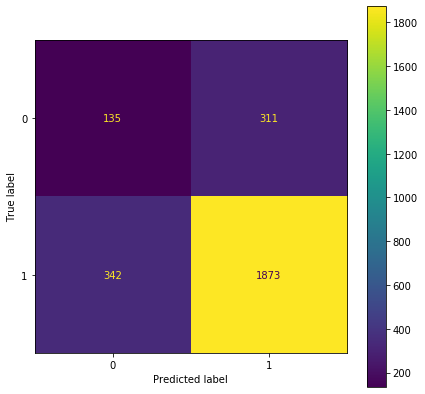



The Metrics train set
              precision    recall  f1-score   support

           0       0.28      0.30      0.29       446
           1       0.86      0.85      0.85      2215

    accuracy                           0.75      2661
   macro avg       0.57      0.57      0.57      2661
weighted avg       0.76      0.75      0.76      2661



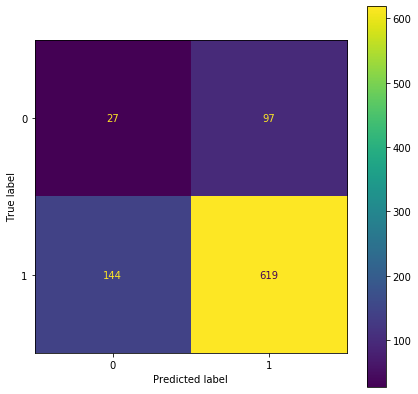



The Metrics test set
              precision    recall  f1-score   support

           0       0.16      0.22      0.18       124
           1       0.86      0.81      0.84       763

    accuracy                           0.73       887
   macro avg       0.51      0.51      0.51       887
weighted avg       0.77      0.73      0.75       887



In [64]:
run_model(nb, X_train_spacy, X_test_spacy, y_train, y_test)

After running Naive Bayse model with 3 different Feature Engineering techniques. My model was overfitting with CountVectorizer and TF-IDF methods, and does not work with Words Embedding 


I will try with Decision model next time

In [65]:
#run_model(nb, X_train_smote, X_test_smote, y_train, y_test)

# Decision Classifier

In [66]:
decision=DecisionTreeClassifier(random_state=10)

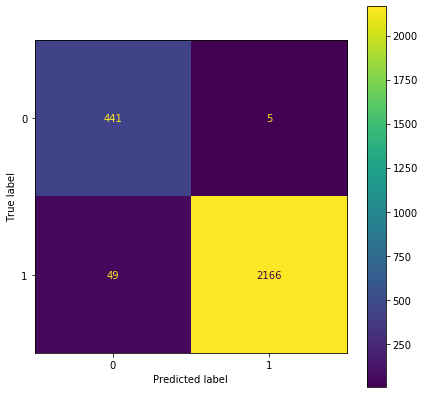



The Metrics train set
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       446
           1       1.00      0.98      0.99      2215

    accuracy                           0.98      2661
   macro avg       0.95      0.98      0.96      2661
weighted avg       0.98      0.98      0.98      2661



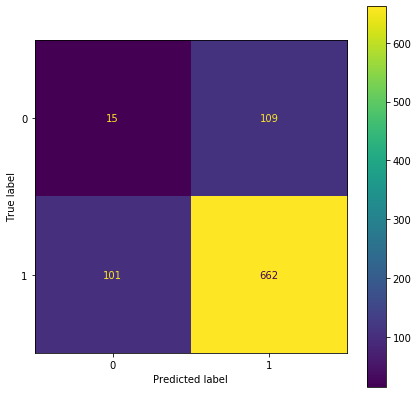



The Metrics test set
              precision    recall  f1-score   support

           0       0.13      0.12      0.13       124
           1       0.86      0.87      0.86       763

    accuracy                           0.76       887
   macro avg       0.49      0.49      0.49       887
weighted avg       0.76      0.76      0.76       887



In [67]:
run_model(decision,X_train_vec.toarray(), X_test_vec.toarray(), y_train, y_test )

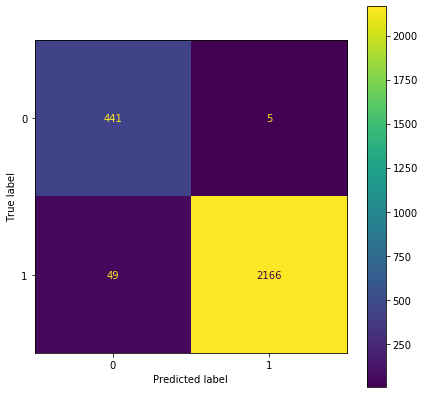



The Metrics train set
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       446
           1       1.00      0.98      0.99      2215

    accuracy                           0.98      2661
   macro avg       0.95      0.98      0.96      2661
weighted avg       0.98      0.98      0.98      2661



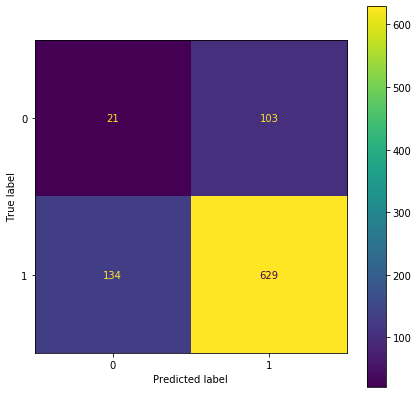



The Metrics test set
              precision    recall  f1-score   support

           0       0.14      0.17      0.15       124
           1       0.86      0.82      0.84       763

    accuracy                           0.73       887
   macro avg       0.50      0.50      0.50       887
weighted avg       0.76      0.73      0.74       887



In [68]:
run_model(decision, X_train_tfidf.toarray(), X_test_tfidf.toarray(), y_train, y_test )

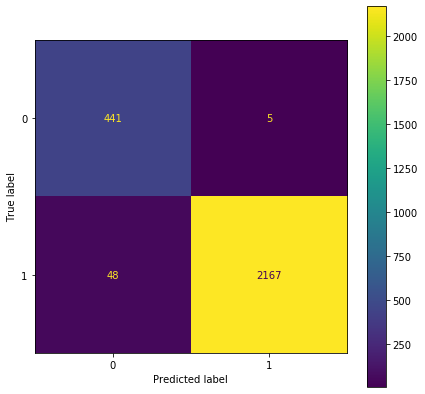



The Metrics train set
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       446
           1       1.00      0.98      0.99      2215

    accuracy                           0.98      2661
   macro avg       0.95      0.98      0.97      2661
weighted avg       0.98      0.98      0.98      2661



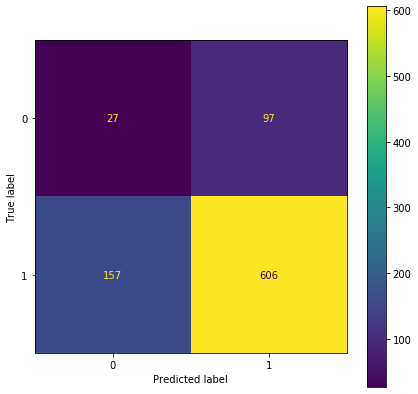



The Metrics test set
              precision    recall  f1-score   support

           0       0.15      0.22      0.18       124
           1       0.86      0.79      0.83       763

    accuracy                           0.71       887
   macro avg       0.50      0.51      0.50       887
weighted avg       0.76      0.71      0.74       887



In [69]:
run_model(decision, X_train_spacy, X_test_spacy , y_train, y_test)

# SMOTE

My model did not work well. I would like to SMOTE my data because it is imbalance. With short of time, I could not figure out how to SMOTE on CountVectorazor and TF-IDF, so I will only SMOTE on Word Embedding method.

In [70]:
data['spacy']=data.text.progress_apply(lambda x: nlp(x))

In [71]:
data_spa = pd.DataFrame(np.vstack([x.vector for x in data['spacy']]))

In [72]:
data_spa.index = np.arange(1, len(data_spa)+1)

In [73]:
#Merge the new spacy data with target to SMOTE 
data_spacy = pd.concat([data_spa, y], axis=1)

In [74]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(data_spa, y)

Train test split again with new data

In [75]:
X_train_smote, X_test_smote, y_train, y_test=train_test_split(X_res, y_res, test_size=.25, random_state=10)

Run the new dataset with Decision Tree

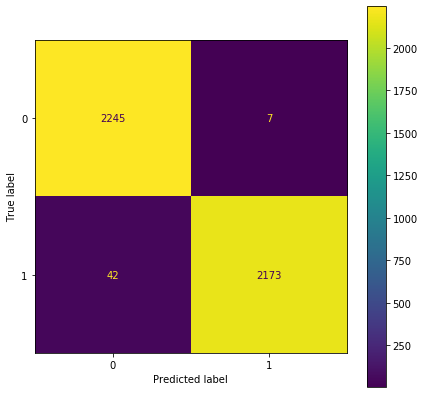



The Metrics train set
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2252
           1       1.00      0.98      0.99      2215

    accuracy                           0.99      4467
   macro avg       0.99      0.99      0.99      4467
weighted avg       0.99      0.99      0.99      4467



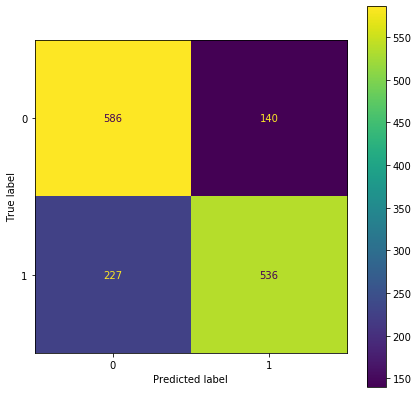



The Metrics test set
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       726
           1       0.79      0.70      0.74       763

    accuracy                           0.75      1489
   macro avg       0.76      0.75      0.75      1489
weighted avg       0.76      0.75      0.75      1489



In [76]:
run_model(decision, X_train_smote, X_test_smote, y_train, y_test)

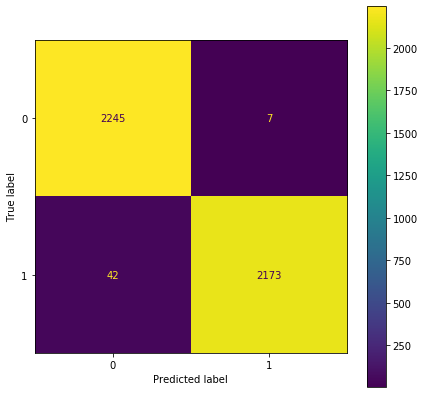



The Metrics train set
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2252
           1       1.00      0.98      0.99      2215

    accuracy                           0.99      4467
   macro avg       0.99      0.99      0.99      4467
weighted avg       0.99      0.99      0.99      4467



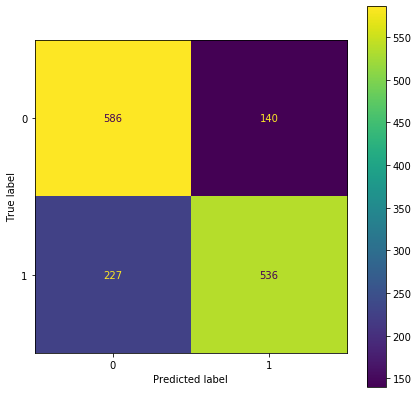



The Metrics test set
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       726
           1       0.79      0.70      0.74       763

    accuracy                           0.75      1489
   macro avg       0.76      0.75      0.75      1489
weighted avg       0.76      0.75      0.75      1489



In [77]:
run_model(decision, X_train_smote, X_test_smote, y_train, y_test)

# GridSearch

Decision Tree model worked pretty well on SMOTE dataset. I will try to do some GridSearch to improve my metrics

In [78]:
tree_para = {'criterion':['gini','entropy'],
            'max_depth':[5,20,40], 
            'min_samples_split': [3, 5, 10],
            }

In [79]:
clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)

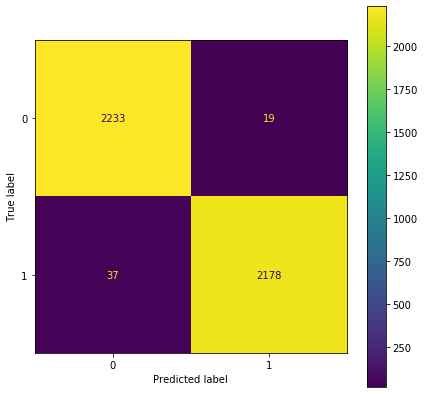



The Metrics train set
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2252
           1       0.99      0.98      0.99      2215

    accuracy                           0.99      4467
   macro avg       0.99      0.99      0.99      4467
weighted avg       0.99      0.99      0.99      4467



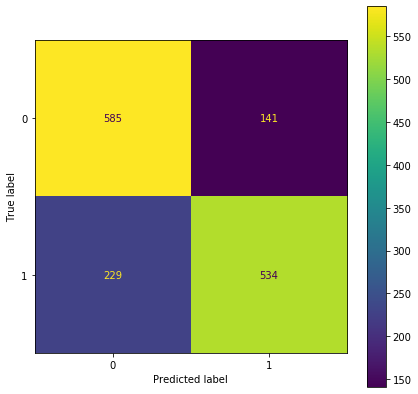



The Metrics test set
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       726
           1       0.79      0.70      0.74       763

    accuracy                           0.75      1489
   macro avg       0.75      0.75      0.75      1489
weighted avg       0.76      0.75      0.75      1489



In [80]:
run_model(clf, X_train_smote, X_test_smote, y_train, y_test)

In [81]:
clf.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=40, min_samples_split=5)

# Final Model

Spent a good amount of time, but GridSearch did not impove my data at all. Therefore, my last model is Decision Tree with SMOTE dataset

In [82]:
clf_final=DecisionTreeClassifier(random_state=10)

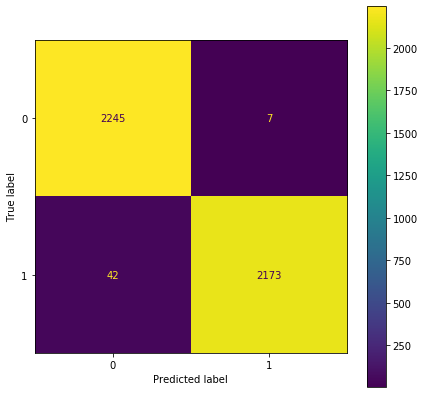



The Metrics train set
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2252
           1       1.00      0.98      0.99      2215

    accuracy                           0.99      4467
   macro avg       0.99      0.99      0.99      4467
weighted avg       0.99      0.99      0.99      4467



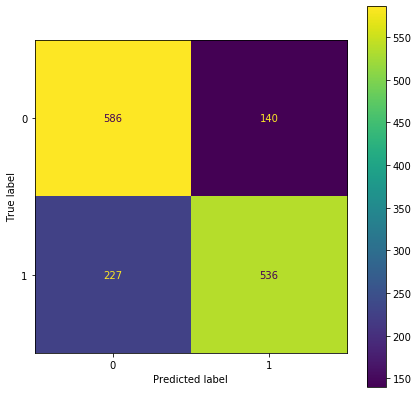



The Metrics test set
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       726
           1       0.79      0.70      0.74       763

    accuracy                           0.75      1489
   macro avg       0.76      0.75      0.75      1489
weighted avg       0.76      0.75      0.75      1489



In [83]:
run_model(clf_final, X_train_smote, X_test_smote, y_train, y_test)

# Future Works

- Try to include "No emotion"

- Try to SMOTE with CountVectorizor and TF-IDF methods

- Do this dataset with Neutral Networks to see any improment metrics